# MoonIndex - M3 indexes filtering and removal

Spectral indexes for the Moon Mineralogical Mapper (M3). This notebook describes the filtering and continuum removal procedure.

Author:Javier Eduardo Suarez Valencia

Contact: jsuarezvalencia@constructor.university

In [3]:
#Importing libraries
import rioxarray as riox
import numpy as np
import MoonIndex.preparation
import MoonIndex.plotting
import MoonIndex.filtration
import MoonIndex.indexes

# Importing data and preparation

The preparation functions are described in the M3_total_indexes notebook.

In [ ]:
#Defining the paths
path_data='/home/jovyan/work/Index/data' #Path to the data
path_results='/home/jovyan/work/Index/results'#Path to the results
target='M3_Apollo' #Name of the used cube

#Import data: raster and wavelengths
input_cube=riox.open_rasterio(f'{path_data}/{target}.tif') 
wavelengths_full=np.loadtxt(f'{path_data}/Wavelength.txt', delimiter=",")  #This file contains the wavelegnths values of M3, it is neccesary to have it
wavelengths_full=(wavelengths_full).astype(np.float32)

#This function attach the wavelength to the cube, sets the no value data to 0 and deletes the two first malfunctioning bands, and the bands after 2700 nm
M3_input_cube=MoonIndex.preparation.attach_wavelen(input_cube,wavelengths_full)

#Cropping the cube
M3_cube=MoonIndex.preparation.crop_cube(M3_input_cube,-151,-31,-150,-30) #Inputs are the cube and the coordinates to crop, minx, miny, maxx, maxy
#Cropping the data with indexes
#M3_cube=MoonIndex.preparation.crop_cube_size(M3_input_cube,25,630,2700,2800)  #Inputs are the cubes and the coordinates of the cropping rectangle (x limits and y limits)

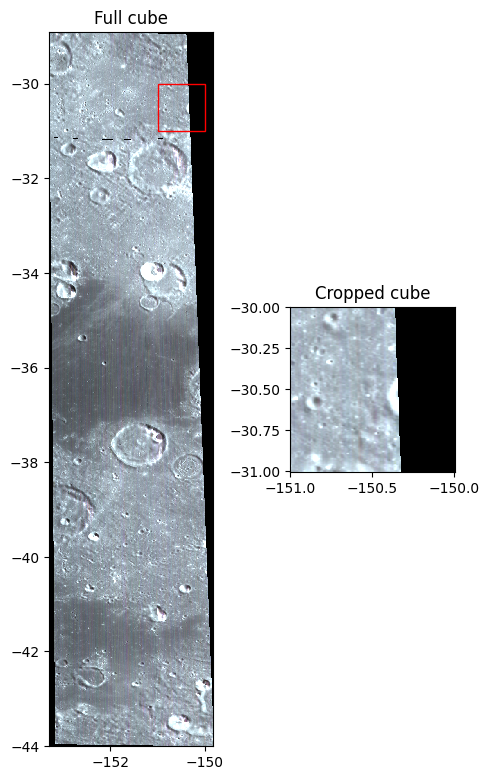

In [4]:
#PROVISIONAL IMPORT
#Import data: raster and wavelengths
input_cube=riox.open_rasterio('M3_Apollo.tiff') 
wavelengths_full=np.loadtxt('Wavelength.txt', delimiter=",")  #This file contains the wavelegnths values of M3, it is neccesary to have it
wavelengths_full=(wavelengths_full).astype(np.float32)

#This function attach the wavelength to the cube, sets the no value data to 0 and deletes the two first malfunctioning bands, and the bands after 2700 nm
M3_input_cube=MoonIndex.preparation.attach_wavelen(input_cube,wavelengths_full)

#Cropping the cube
M3_cube=MoonIndex.preparation.crop_cube(M3_input_cube,-151,-31,-150,-30) #Inputs are the cube and the coordinates to crop, minx, miny, maxx, maxy
#Cropping the data with indexes
#M3_cube=MoonIndex.preparation.crop_cube_size(M3_input_cube,25,630,2700,2800)  #Inputs are the cubes and the coordinates of the cropping rectangle (x limits and y limits)

# Smoothing of the Spectra

M3 data shows vertical stripes that sometimes make it difficult to interpret the data. Shkuratov et al. (2019) developed a workflow to enhance the quality of the data, which include a fourier and a gaussian filtration.

C:\Users\javie\.conda\envs\spectral\Lib\site-packages\MoonIndex\plotting.py:66: RuntimeWarning: divide by zero encountered in log
  mshift_mask_mag = 20 * np.log(cv2.magnitude(mfouraster2[:, :, 0], mfouraster2[:, :, 1]))  #For plotting


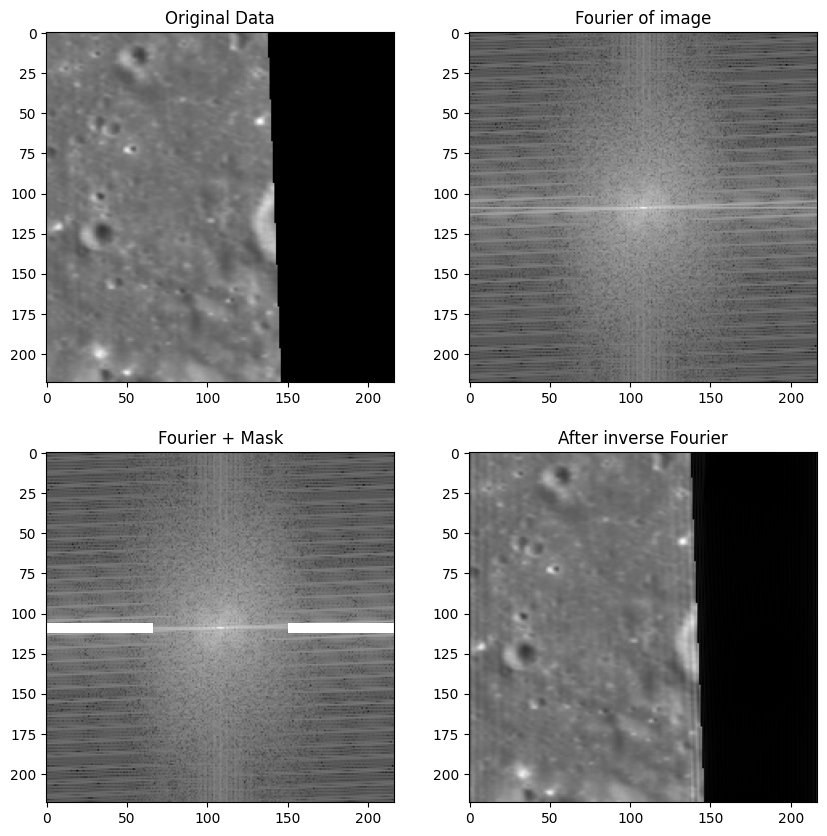

In [5]:
#Doing a fourier filtration, suggested size of the filter is 60x2
filter_width=60
filter_height=2
M3_fourier=MoonIndex.filtration.fourier_filter(M3_cube,filter_width,filter_height)  #Inputs the cube, and width and altitude of the mask in total percentage

#Plotting to check, the second image are the frequencies in the fourier domain, 
#the third one is the same image with the filter on top, last image is the output fitlered image.
MoonIndex.plotting.fourier_plot(M3_cube,5,filter_width,filter_height)  #Inputs the cube, band, and width and altitude of the mask in total percentage

<module 'matplotlib.pyplot' from 'C:\\Users\\javie\\.conda\\envs\\spectral\\Lib\\site-packages\\matplotlib\\pyplot.py'>

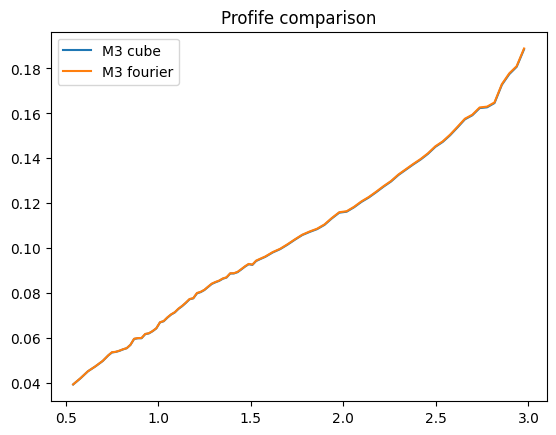

In [6]:
#Comparing a spectral signature before and after the gaussian fitler, the pixel is selected
#at random, the user can input any pixel
MoonIndex.plotting.profiles_comparison(wavelengths_full,M3_cube.data,M3_fourier.data,"M3 cube","M3 fourier", 100,55,3)  #Inputs are the cubes to compare, wavelengths, their names, pixel x, y, and roi

To check that actual data is not being lost during the filtering, we first check the ratio between the input and output, it should show lunar features if data is being lost. Secondly, we mapped the pixels that changed more than 2% after the filter, which are the pixel mapped with values of 0. As seen in both cases, the affected information is related to the vertical stripes and not the spectral data.

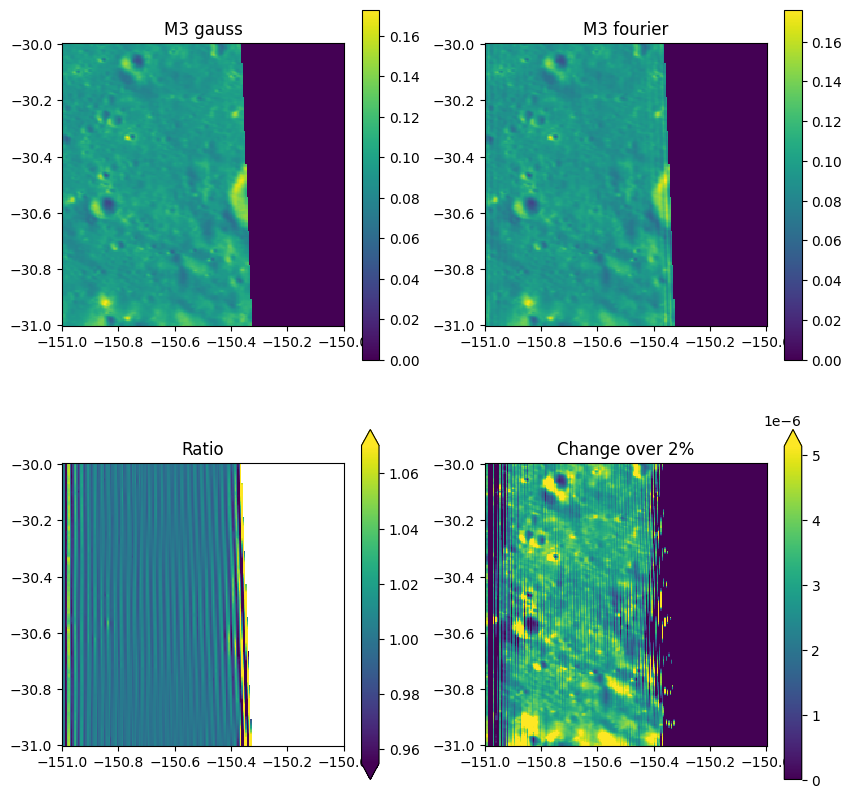

In [7]:
#Plotting the images to compare, the band 40 was choosen randomly, the user can use other one
MoonIndex.plotting.filter_comparison(M3_cube,M3_fourier,"M3 gauss", "M3 fourier",40) #Inputs are the cubes to compare, their names, and the band

<module 'matplotlib.pyplot' from 'C:\\Users\\javie\\.conda\\envs\\spectral\\Lib\\site-packages\\matplotlib\\pyplot.py'>

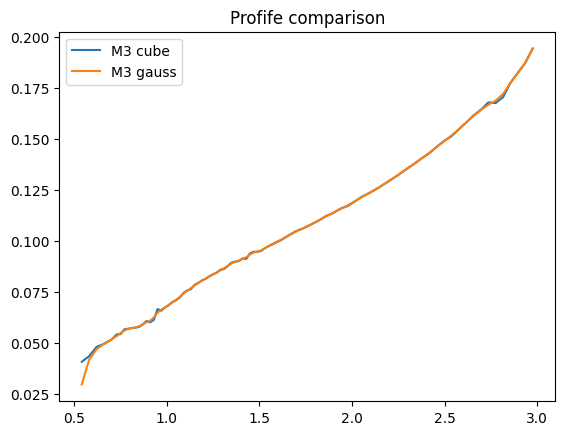

In [8]:
#Doing a gaussian filtration
M3_gauss=MoonIndex.filtration.gauss_filter(M3_fourier,wavelengths_full)  #Inputs are the original cube and wavelengths
#M3_gauss.rio.to_raster(f'{path_results}/{target}_Filtered.tif') Uncomment if you want to create an only-filtered cube

#Comparing a spectral signature before and after the gaussian fitler, the pixel is selected
#at random, the user can input any pixel
MoonIndex.plotting.profiles_comparison(wavelengths_full,M3_fourier.data,M3_gauss.data,"M3 cube","M3 gauss",123, 56,3)  #Inputs are the cubes to compare, wavelengths, their names, pixel x, y, and roi

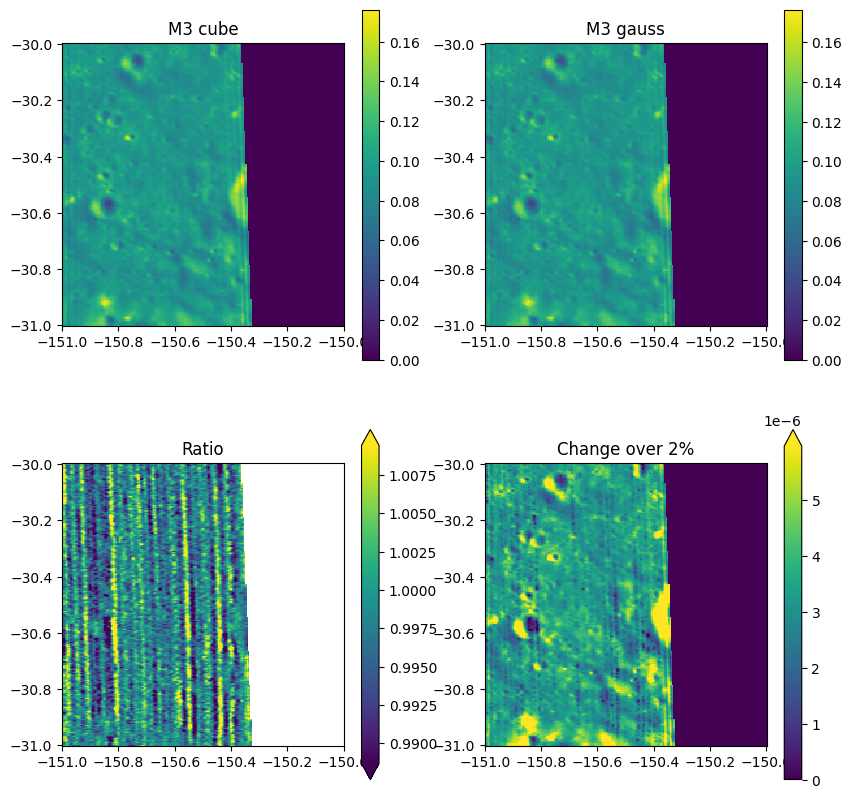

In [9]:
#Plotting the images to compare, the band 40 was choosen randomly, the user can use other one
MoonIndex.plotting.filter_comparison(M3_fourier,M3_gauss,"M3 cube", "M3 gauss",40) #Inputs are the cubes to compare, their names, and the band

# Continuum removal with the convex hull method

In order to obtain the indexes, it is necessary to extract the continuum of the spectra to properly locate the absorption centers, shoulders and depths. There are several methods to do it, in this case we the convex hull removal method, following Shkuratov et al. (2019), as it is straightforward and correctly derives the properties of the spectrum.

A problem of M3 spectra is its steep upwards slope, that difficults the convex hull application. To solve that, we previously created a tie-point with the local maxima between 1000 and 1500 nm, so it could be added to the convex hull and the absorption peak would not be missed.

In [10]:
#Function to find the midpoint to add to the convexhull
M3_midpoint=MoonIndex.preparation.midpoint(M3_gauss,wavelengths_full,6,0.002)  #Inputs are the filtered cube, the wavelengths, and the distance and prominence of the peaks

In [11]:
#Function to remove the continnum by the convex hull method, it is computed only until 2700 nm
M3_hull = MoonIndex.preparation.convexhull_removal(M3_gauss,wavelengths_full, M3_midpoint)  #Inputs are the filtered cube, wavelengths and the midpoint

<module 'matplotlib.pyplot' from 'C:\\Users\\javie\\.conda\\envs\\spectral\\Lib\\site-packages\\matplotlib\\pyplot.py'>

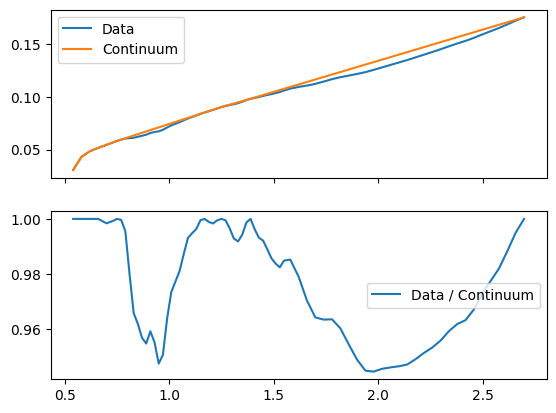

In [12]:
#Convex hull plotting, the pixel was selcted randomly, the user can enter another one
MoonIndex.plotting.convexhull_plot(M3_gauss.data,wavelengths_full, M3_midpoint.data,20,80) #Inputs are filtered cube, wavelengths, midpoint,x, y

In [14]:
#Exporting the continumm removed cube
M3_hull_export=M3_hull.copy()
M3_hull_export.data[M3_hull_export.data==0]=np.nan
#M3_hull_export.rio.to_raster(f'{path_results}/{target}_conremoved_CH.tif') Uncomment if you want to export the continuum-removed file

The band minimum is a key value to create the indexes. The find minimums function looks for: 1. The minimum value of the continuum removed cube between 540 nm and the midpoint, for the 1000 nm minimum. 2. The minimum value of the continuum removed cube between the midpoint and 2696.73 nm, for the 2000 nm minimum. Then it stores the wavelength of that minimum.

In [15]:
# Making rasters with the wavelength of minimum reflectance in 1000 um and 2000 um respectively
M3_min1000, M3_min2000=MoonIndex.preparation.find_minimums_ch(M3_hull,M3_midpoint,wavelengths_full)  #Inputs are the convex hull and wavelengths, outputa the two minimums

The other key value to make the indexes are the band shoulders. Thi find shoulders function looks in the continuum removed cube for the maximums between 540 nm and the minimum at 1000 nm, then between the minimum and the tiepoint, this defines the left and right shoulders of the 1000 nm minimuum respectively.

Then it does the same between te tiepoint and the minimum at 2000 nm, and between the minimum at 2000 nm and 2736.65 nm, this defines the left and right shoulders of the 2000 nm minimuum respectively.

In [16]:
#Obtaining the shoulders, point of maximum reflectance beetween the minimum
M3_shoulder0, M3_shoulder1, M3_shoulder2, M3_shoulder3=MoonIndex.preparation.find_shoulders_ch(M3_hull,M3_midpoint,M3_min1000,M3_min2000,wavelengths_full)  #Inputs convex hull and wavelengths, outputs the four shoulders

# Linear fit continuum removal method

The linear-fit removal method does not iterate over the full spectrum, instad it makes a 2 order fit in the 1000 nm region and a linear fit in the 2000 nm region. The definition of the fit positions is derived from literature (Zambon et al., 2020), the 1000 nm fit is done between then ranges 580-770 nm and 1400-1469 nm, and the fit in 2000 nm between the last point and 2656 nm. he minimums and shoudlers are ten calculated using this continnum-removed spectrum.

The main disadvantage of tihs method is the arbitrary selection of the interpolation points.

In [17]:
#Continuum removal with the linear fit method
M3_lf=MoonIndex.preparation.continuum_removal_lf(M3_gauss,wavelengths_full,2,1) #Inptus are the filtered cube, wavelegnths, and the order of the polynomial fit for the 1000 nm and 2000 nm band
#M3_lf.rio.to_raster(f'{path_results}/{target}_conremoved_LF.tif') Uncomment if you want to export the continuum-removed file

<module 'matplotlib.pyplot' from 'C:\\Users\\javie\\.conda\\envs\\spectral\\Lib\\site-packages\\matplotlib\\pyplot.py'>

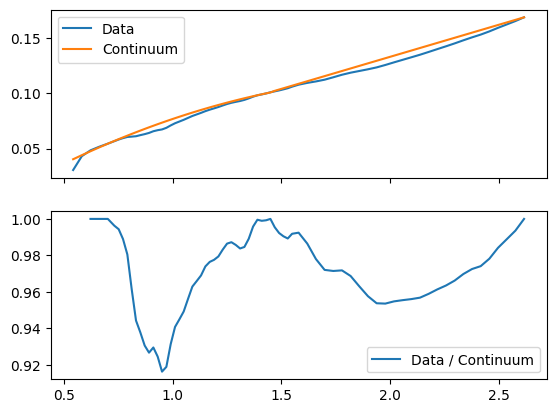

In [18]:
#Plotting of the contunnum removed spectrum
MoonIndex.plotting.linearfit_plot(M3_gauss,M3_lf,wavelengths_full,20,80)

In general we can see that the convexhull understimates the band depth around 1000 mn, probably due to the use of a second order in the fit method, appart from that, the position of the minimmuns are consistent.

<module 'matplotlib.pyplot' from 'C:\\Users\\javie\\.conda\\envs\\spectral\\Lib\\site-packages\\matplotlib\\pyplot.py'>

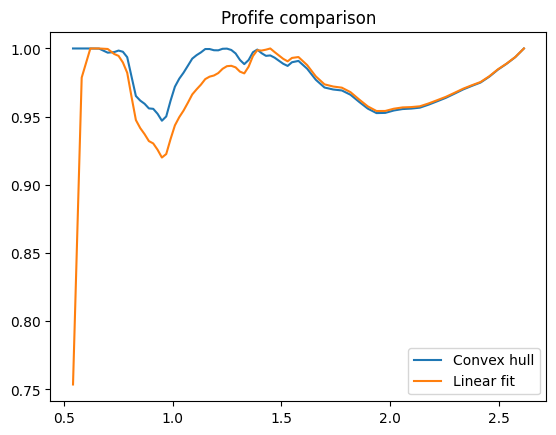

In [20]:
#Comapring the continnum removal between the two methoda
MoonIndex.plotting.profiles_comparison(wavelengths_full,M3_hull,M3_lf, "Convex hull", "Linear fit",20,80,3)

In [21]:
#Minimuums calculation with the linear fit method
M3_min1000lf,M3_min2000lf=MoonIndex.preparation.find_minimuumslf(M3_lf,wavelengths_full)

In [22]:
#Maximums calculation with the linear fit method
M3_shoulder0lf,M3_shoulder1lf,M3_shoulder2lf=MoonIndex.preparation.find_shoulders_lf(M3_lf,M3_min1000lf,M3_min2000lf,wavelengths_full)

# References

Bretzfelder, J. M., Klima, R. L., Greenhagen, B. T., Buczkowski, D. L., Petro, N. E., & Day, M. (2020). Identification of Potential Mantle Rocks Around the Lunar Imbrium Basin. Geophysical Research Letters, 47(22). https://doi.org/10.1029/2020GL090334

Clenet, H. (2009). Télédétection hyperspectrale: Minéralogie et pétrologie, Application au volcan Syrtis Major (Mars) et à l’ophiolite d’Oman. Université de Toulouse.

Corley, L. M., McGovern, P. J., Kramer, G. Y., Lemelin, M., Trang, D., Gillis-Davis, J. J., Taylor, G. J., Powell, K. E., Kiefer, W. S., Wieczorek, M., & Zuber, M. T. (2018). Olivine-bearing lithologies on the Moon: Constraints on origins and transport mechanisms from M3 spectroscopy, radiative transfer modeling, and GRAIL crustal thickness. Icarus, 300, 287-304. https://doi.org/10.1016/j.icarus.2017.09.012

Horgan, B. H. N., Cloutis, E. A., Mann, P., & Bell, J. F. (2014). Near-infrared spectra of ferrous mineral mixtures and methods for their identification in planetary surface spectra. Icarus, 234, 132-154. https://doi.org/10.1016/j.icarus.2014.02.031

Shkuratov, Yu., Surkov, Ye., Ivanov, M., Korokhin, V., Kaydash, V., Videen, G., Pieters, C., & Stankevich, D. (2019). Improved Chandrayaan-1 M3 data: A northwest portion of the Aristarchus Plateau and contiguous maria. Icarus, 321, 34-49. https://doi.org/10.1016/j.icarus.2018.11.002

Zambon, F., Carli, C., Altieri, F., Luzzi, E., Combe, J.-P., Ferrari, S., Tognon, G., & Massironi, M. (2020). Spectral Index and RGB maps—Beethoven, Rembrandt basins on Mercury, Apollo basin and Leibnitz and Von Karman craters regions on the Moon (p. 57).